In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

import nltk
from sklearn import cross_validation
from sklearn import datasets, linear_model, utils, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import csv
from string import punctuation
import nltk
from nltk.stem import WordNetLemmatizer
import collections

In [2]:
### step 1: load data
data = pd.read_csv('dailynews_csv.csv', encoding='latin-1') #load csv file into python as pandas dataframe, can select different encoding method depending on raw data format
data.head() #view top rows of the dataframe in python

,date,news,Adj_Close,delta,normalized
0,10/9/15,CFPB Investigates Wells Fargo over Student-Loa...,2014.890015,0.000000,-0.182287
1,10/13/15,Two Data Breaches Revealed; Cyber Premiums on ...,2003.689941,-0.005559,-0.340196
2,10/14/15,UBS Reaches $19.5M SEC Settlement\rUBS yesterd...,1994.239990,-0.004716,-0.473429
3,10/15/15,BoE Issues Ringfencing Rules \rThe Bank of Eng...,2023.859985,0.014853,-0.055821
4,10/16/15,UK Releases Money-Laundering Risk Assessment\r...,2033.109985,0.004570,0.074593


In [3]:
### step 2: set dependent and independent variables
news = data['news']

data['Adj_Close'] = data['Adj_Close'].astype(float)
close = data['Adj_Close']

independent = news
dependent = close

In [4]:
### step 3: This part tokenizes text, converts text independent variable into a matrix of terms, and prepares for modeling

## 1) Bag of words model
default_tokenizer = CountVectorizer().build_tokenizer()
stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)
def tokenize_stem(text):
    tokens = default_tokenizer(text)
    stemmed = map(stemmer.stem, tokens)
    return stemmed

vec1 = CountVectorizer(max_df = 10, min_df = 1, # pick terms within frequency boundaries
                       stop_words=map(stemmer.stem, nltk.corpus.stopwords.words('english')),
                       tokenizer=tokenize_stem)

fit1 = vec1.fit(independent)
transformed1 = fit1.transform(independent)

#print vec1.get_feature_names() # displays terms used in modeling

## 2) TF-IDF

default_tokenizer = TfidfVectorizer().build_tokenizer()
stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)
    
def tokenize_stem(text):
    tokens = default_tokenizer(text)
    stemmed = map(stemmer.stem, tokens)
    return stemmed

vec2 = TfidfVectorizer(max_df = 10, min_df = 1,
                         stop_words=map(stemmer.stem, nltk.corpus.stopwords.words('english')),
                         tokenizer=tokenize_stem)

fit2=vec2.fit(independent)
transformed2 = fit2.transform(independent)

#print vec2.get_feature_names() # displays terms used in modeling


In [5]:
### step 4: This part build a linear regression using text terms 
X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
                    transformed1, dependent, test_size=0.4, random_state=42) 
reg1 = linear_model.LinearRegression()
reg1.fit(X_train, y_train)
print 'Bag of Words r^2 is', reg1.score(X_test, y_test)
pre1 = reg1.predict(transformed1) # predicted dependent variable series

X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
                    transformed2, dependent, test_size=0.4, random_state=42) 
reg2 = linear_model.LinearRegression()
reg2.fit(X_train, y_train)
print 'TF-IDF r^2 is', reg2.score(X_test, y_test)
pre2 = reg2.predict(transformed2) # predicted dependent variable series

Bag of Words r^2 is 0.0960805794703
TF-IDF r^2 is 0.0706519890014


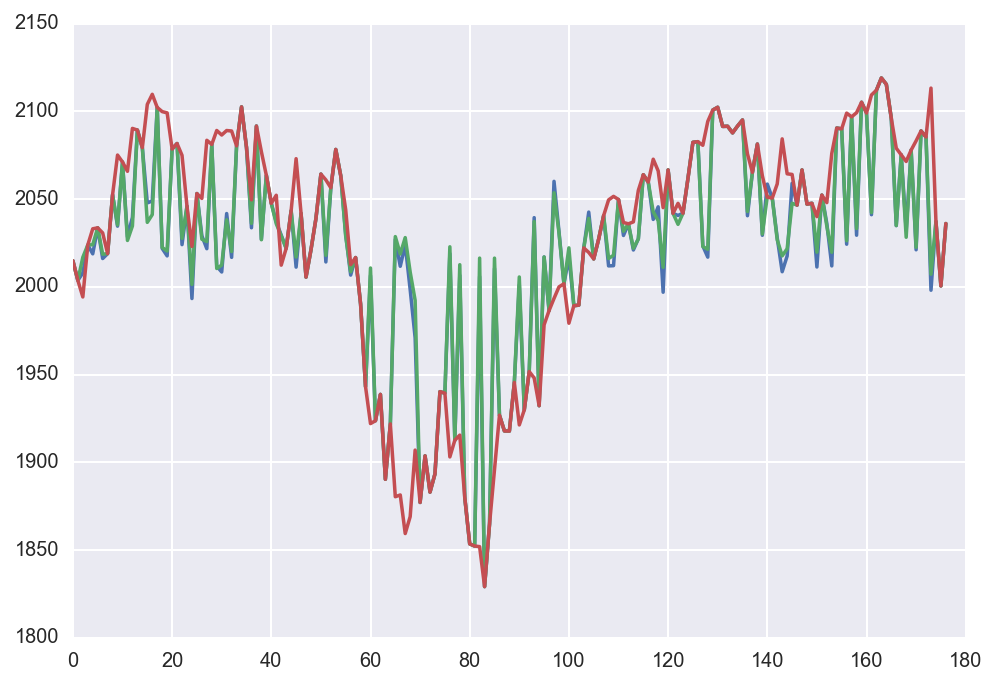

In [6]:
### step 5: fit vs. actual plot
plt.plot(pre1)
plt.plot(pre2)
plt.plot(dependent)

In [7]:
### step 6: sentiment term extraction # basically same with professor's code but I made modifications to load csv files

## SET VARIABLES HERE
#====================================

# define location and name of input file
infile = 'dailynews_csv2.csv' # this csv file should contain one column of text, the code analyzes text cell by cell

# define location and name of output file
outfile = 'text_sentiment_test.csv'

#set paths for sentiment lexicons
negfile = 'LabSession_jun6/resources/OpinionLexiconNeg.txt'
posfile = 'LabSession_jun6/resources/OpinionLexiconPos.txt'

#====================================
## PREPARATION

#read files and components we need
#negative = open(negfile, 'r', encoding='utf8').read().split('\n')
#positive = open(posfile, 'r', encoding='utf8').read().split('\n')
negative = open(negfile, 'r').read().split('\n')
positive = open(posfile, 'r').read().split('\n')
lemmatizer = WordNetLemmatizer()    #NLTK lemmatizer module

#====================================
#FUNCTIONS

#given a text, segments the tokens, puts in lowercase, removes numbers, null tokens and punctuation
def tokenize(text):
    toknopunct = []
    tokens = nltk.wordpunct_tokenize(text)
    tokens = [t.lower() for t in tokens]
    #tokens = [item.translate(None, '1234567890') for item in tokens]
    for t in tokens:
        if t not in list(punctuation) and t != '':
            toknopunct.append(t)
    return toknopunct

#given a list of words, lemmatize them
def lemmatize(words):
    lemmas = [lemmatizer.lemmatize(w) for w in words]
    return lemmas
    
#given a list of words, it identifies the positive and negative sentiment terms
# and returns them in a list (one for positive set, one for negative)
def sentimentator(words):
    neg_words = []
    pos_words = [] 
    # for each word, check for sentiment words
    for w in words:
        if w in negative:
            neg_words.append(w)   #add negative word to the list
        elif w in positive:
            pos_words.append(w)  #add positive word to the list
    return (sorted(pos_words), sorted(neg_words))
    
#given a list of words, returns a tuple of (word, frequency)
def word_freq(words):
    counter = collections.Counter(words)
    return counter

#given a list of words, generates a string of words separated by comma
def create_string_from_list(wordlist):
    return ", ".join(wordlist)

#given a list of analyzed elements (strings and lists), it generates a CSV file
#Each parameter is a column header   
def create_csv():
    mycsv = open(outfile, 'a')     #'a' for append
    out = csv.writer(mycsv, delimiter=',', quoting=csv.QUOTE_ALL)
    out.writerow(["word count", "proportion neg", "proportion pos", "sentiment score", "negative list", "positive list"])
    mycsv.close()
        
def add_to_csv(wordcnt, negprop, posprop, sentscore, neglist, poslist):
    mycsv = open(outfile, 'a')     #'a' for append
    out = csv.writer(mycsv, delimiter=',', quoting=csv.QUOTE_ALL)
    out.writerow([wordcnt, negprop, posprop, sentscore, neglist, poslist])
    mycsv.close()

#====================================
#MAIN PART OF SCRIPT
#####################
#create the output CSV file to fill in as analysis is done on files
create_csv()
print("Now processing: ", infile)
print("Computing sentiment per tweet")

#for each tweet in the file, find the positive and negative sentiment words

# read the tweets file and save tweets in a list
#tweets = open(infile,'r', encoding='utf8').read()
#tweets = open(infile,'r').read()

with open(infile, 'r') as csvfile:
    tweet_list = [str(row) for row in csv.reader(csvfile.read().splitlines())]
    #tweets = csv.reader(csvfile, dialect=csv.excel_tab)
    #for row in tweets:
    #    tweet_list.append(row)

#tweets = open(infile, 'r')
#tweet_list = tweets.split('\n')

for tweet in tweet_list:
    if tweet == '':
        pass
    else:
        #analysis:
        #~~~~~~~~~
        words = tokenize(tweet)  #tokenize: extract tokens using tokenize() function
        #lemmas =lemmatize(words) #get the lemma forms of each word
    
        #calls the sentimentator() function that returns pos/neg terms for this tweet, 
        #sorted alphabetically
        positive_words, negative_words = sentimentator(words)
        #compute the sentiment proportions: divide number of sent words by all words in tweet
        if len(words) > 0:
            posprop = len(positive_words)/float(len(words))
            negprop = len(negative_words)/float(len(words))
        else:
            pass
        #compute sentiment score using Laplacian smoothing
        positive_ratio = float(len(positive_words)+1) / float(len(positive_words)+len(negative_words)+2)
            
        #frequency count for each polarity term found in tweet
        neg_frequency = word_freq(negative_words)
        pos_frequency = word_freq(positive_words)
        
        #====================================
        ## PREPARE TO PRINT OUT
        #====================================
                    
        # Convert format of frequency lists | prepare for CSV output
    
        #convert tuple format to dictionary format
        negativelist = []
        positivelist = []
        negdict = dict(neg_frequency)
        posdict = dict(pos_frequency)

        #write out words to lists
        for w in sorted(negdict, key=negdict.get, reverse=True):
            negativelist.append("%s:%d" % (w, negdict[w]))
        for w in sorted(posdict, key=posdict.get, reverse=True):
            positivelist.append("%s:%d" % (w, posdict[w]))        
            
        #====================================
        ## PRINT RESULTS TO CSV FILE
        
        # Print output of analysis to a CSV file, one file per row
        # using the create_csv function
        add_to_csv(len(words), negprop, posprop, positive_ratio, negativelist, positivelist)

print("Output is in ", outfile)

('Now processing: ', 'dailynews_csv2.csv')
Computing sentiment per tweet
('Output is in ', 'text_sentiment_test.csv')


In [ ]:
### step 7: load extracted sentiment terms into python again, reset variables and repeat model creation using steps 1-5.